In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras import layers
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

Building the autoencoder

In [ ]:
def build_auto(input_dim, encoding_dim=10):
    input_layer = keras.Input(shape=(input_dim,))

    # Encoder
    encoded = layers.Dense(75, activation='relu')(input_layer)
    encoded = layers.Dropout(0.2)(encoded)
    encoded = layers.Dense(45, activation='relu')(encoded)
    encoded = layers.Dropout(0.2)(encoded)
    encoded = layers.Dense(encoding_dim, activation='relu')(encoded)

    # Decoder
    decoded = layers.Dense(45, activation='relu')(encoded)
    decoded = layers.Dropout(0.2)(decoded)
    decoded = layers.Dense(75, activation='relu')(decoded)
    decoded = layers.Dropout(0.2)(decoded)
    decoded = layers.Dense(input_dim, activation='linear')(decoded)

    autoencoder = keras.Model(inputs=input_layer, outputs=decoded)
    autoencoder.compile(optimizer='adam', loss='mse')
    return autoencoder

Imputation

In [ ]:
def impute_with_auto(X_incomplete, encoding_dim=10, epochs=100, batch_size=32, validation_split=0.2):
    missing_mask = X_incomplete.isnull()

    # Temporary mean imputation
    X_temp = X_incomplete.fillna(X_incomplete.mean())

    # Normalize
    scaler = StandardScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X_temp), columns=X_temp.columns, index=X_temp.index)

    # Use only complete rows
    complete_rows = ~missing_mask.any(axis=1)
    X_complete = X_scaled[complete_rows]
    per_comp=(X_complete.shape[0]/4240)*100;
    print("Percentage of complete rows:",per_comp, "%")

    # Build and train autoencoder
    autoencoder = build_auto(input_dim=X_scaled.shape[1], encoding_dim=encoding_dim)
    history = autoencoder.fit(
        X_complete, X_complete,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=validation_split,
        shuffle=True,
        verbose=1
    )

    # Reconstruct dataset
    X_reconstructed = autoencoder.predict(X_scaled)
    X_reconstructed = pd.DataFrame(X_reconstructed, columns=X_scaled.columns, index=X_scaled.index)
    # Impute missing values
    X_imputed_scaled = X_scaled.copy()
    X_imputed_scaled[missing_mask] = X_reconstructed[missing_mask]

    reconstruction_quality(X_complete, autoencoder)


    return X_imputed_scaled, missing_mask, history

Total missing values: 645
Percentage of complete cases: 86.27%
Percentage of complete rows: 86.27358490566037 %
Epoch 1/150
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.9009 - val_loss: 0.9594
Epoch 2/150
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7838 - val_loss: 0.8041
Epoch 3/150
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7199 - val_loss: 0.7410
Epoch 4/150
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6234 - val_loss: 0.6409
Epoch 5/150
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5916 - val_loss: 0.5336
Epoch 6/150
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5489 - val_loss: 0.4539
Epoch 7/150
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4937 - val_loss: 0.4129
Epoch 8/150
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.4769 - val_loss: 0.3821
Epoch 9/150
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4378 - val_loss: 0.3501
Epoch 10/150
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4333 - val_loss: 0.3413
Epoch 11/150
46/46 ━━━━━━━━━━━━━━━━━━

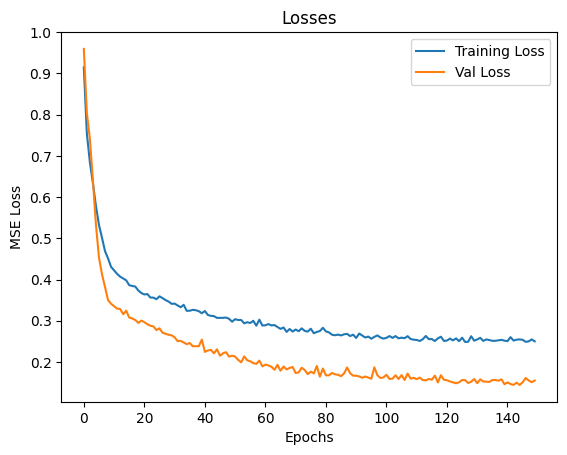

In [ ]:
def main():
    df = pd.read_csv('/framingham_heart_study.csv')

    X = df.iloc[:, :15]  # Features
    y = df.iloc[:, 15]   # Target

    missing_info = df.isnull().sum()
    print("Total missing values:", missing_info.sum())
    print("Percentage of complete cases: {:.2f}%".format((~df.isnull().any(axis=1)).mean() * 100))

    # Perform imputation
    X_imputed, missing_mask, history= impute_with_auto(
        X,
        encoding_dim=8,
        epochs=150,
        batch_size=64,
        validation_split=0.2
    )

    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title("Losses")
    plt.xlabel("Epochs")
    plt.ylabel("MSE Loss")
    plt.legend()
    # Adding target column
    df_imputed = X_imputed.copy()
    df_imputed['target'] = y.reset_index(drop=True)

    # Saving imputed dataset
    df_imputed.to_csv("framingham_imputed_normalized.csv", index=False)

    LDA_fn(df_imputed)


if __name__ == "__main__":
    main()


In [ ]:
def reconstruction_quality(X_complete, autoencoder):
    from sklearn.metrics import mean_squared_error, r2_score

    X_reconstructed = autoencoder.predict(X_complete)

    rmse = np.sqrt(mean_squared_error(X_complete.values.flatten(), X_reconstructed.flatten()))
    r2 = r2_score(X_complete.values.flatten(), X_reconstructed.flatten())
    mae = np.mean(np.abs(X_complete.values.flatten() - X_reconstructed.flatten()))

    print(f"\nReconstruction quality:")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R²: {r2:.4f}")

LDA

In [ ]:
def LDA_fn(df_imputed):
 from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

 X = df_imputed.drop(columns=["target"])
 y = df_imputed["target"]  #integer for classification

 # Create LDA object and apply it
 lda = LDA(n_components=1)  # For binary classification, n_components = 1
 X_lda = lda.fit_transform(X, y)

 # You can optionally create a new DataFrame
 X_lda_df = pd.DataFrame(X_lda, columns=["LDA_Component_1"])

 #add target again
 final_df = pd.concat([X_lda_df, y.reset_index(drop=True)], axis=1)
 final_df.to_csv("Post_LDA_dataset.csv", index=False)
 print("LDA performed")

 return final_df